# Rock, Paper, Scissors

#### Import modules

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy
import matplotlib.pyplot as plt
import os
import random
import sklearn
from sklearn.model_selection import StratifiedKFold
import pandas
from seaborn import boxplot
from matplotlib import pyplot
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay
import pickle

#### Default values

In [2]:
# IMPORT IMAGES
dir_images_train = "C:\\zImagens\\train"
image_size = (128,128)
batch_size = 32

# TRAINING
the_seed = 32
input_shape = image_size + (1,)
convnn_activation = 'relu'
fully_connected_activation = 'tanh'
hyperparameter_max = 10
learning_rate = 0.001
patience = 25
max_epochs = patience * 40
score_metric = 'accuracy'
verbose = 0
phi = 359
n_folds = 5

# SET RANDOM
random.seed(the_seed)
numpy.random.seed(the_seed)
tf.random.set_seed(the_seed)

#### Import images to training dataset

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=dir_images_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

train_images = []
train_labels = []

for image, label in train_ds:
    train_images.append(image.numpy())
    train_labels.append(label.numpy())

train_images = numpy.concatenate(train_images, axis = 0)
train_labels = numpy.concatenate(train_labels, axis = 0)

class_names = train_ds.class_names

Found 4741 files belonging to 3 classes.


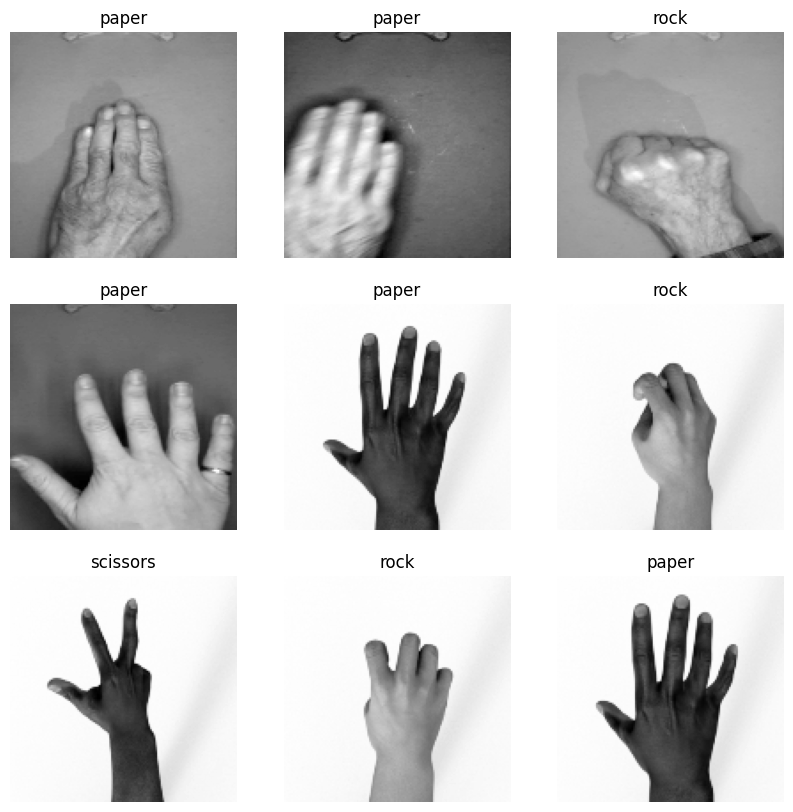

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

#### Training

In [5]:
def create_rps(input_size : tuple[int, int, int] = (128,128, 1),
                      convnn_activation : str = 'relu',
                      fully_connected_activation : str = 'softmax',
                      net_name : str = 'RPS',
                      hyperparameter : int = 1):
    
    filter_size = (3,3)
    pooling_size = (2,2)
    
    # CAMADA OCULTA
    inputs = tf.keras.Input(shape=input_size)
    
    # RESCALING
    scale_layer = tf.keras.layers.Rescaling(scale= 1/127.5, offset=-1)
    x = scale_layer(inputs)
    
    # CAMADA DE AUMENTO DE DADOS
    flip = tf.keras.layers.RandomFlip(mode='horizontal_and_vertical')
    x = flip(x)
    rotator = tf.keras.layers.RandomRotation(factor=0.5)
    x = rotator(x)

    # PRIMEIRA CAMADA CONVOLUCIONAL + POOL
    conv_2d_layer_1 = tf.keras.layers.Conv2D(2 * hyperparameter, filter_size, activation = convnn_activation)
    x = conv_2d_layer_1(x)
    maxpool_1 = tf.keras.layers.MaxPooling2D(pooling_size)
    x = maxpool_1(x)

    # SEGUNDA CAMADA CONVOLUCIONAL + POOL
    conv_2d_layer_2 = tf.keras.layers.Conv2D(4 * hyperparameter, filter_size, activation = convnn_activation)
    x = conv_2d_layer_2(x)
    maxpool_2 = tf.keras.layers.MaxPooling2D(pooling_size)
    x = maxpool_2(x)

    # TERCEIRA CAMADA CONVOLUCIONAL + POOL
    conv_2d_layer_3 = tf.keras.layers.Conv2D(8 * hyperparameter, filter_size, activation = convnn_activation)
    x = conv_2d_layer_3(x)
    maxpool_3 = tf.keras.layers.MaxPooling2D(pooling_size)
    x = maxpool_3(x)

    # FLATTEN
    flatten_layer = tf.keras.layers.Flatten()
    x = flatten_layer(x)

    # FULLY CONNECTED HIDDEN LAYER
    hidden_layer = tf.keras.layers.Dense(128 * hyperparameter, activation = convnn_activation)
    x = hidden_layer(x)

    # OUTPUT LAYER
    output_layer = tf.keras.layers.Dense(3, activation = fully_connected_activation)
    outputs = output_layer(x)

    return tf.keras.Model(inputs = inputs, outputs = outputs, name = net_name)

In [6]:
result_list = []
kfolder = StratifiedKFold(n_splits = n_folds, random_state = the_seed, shuffle = True)
early_stopping = EarlyStopping(monitor = "val_loss", patience = patience, restore_best_weights = True, verbose = verbose) 

for hyperparameter in numpy.arange(1, hyperparameter_max + 1):
    for i, (train_index, validation_index) in enumerate(kfolder.split(train_images, train_labels)):
        print(f"Starting h: {hyperparameter} f: {i}")
        X_train, Y_train = train_images[train_index], train_labels[train_index]
        X_val, Y_val = train_images[validation_index], train_labels[validation_index]
        
        # NET NAME > Hyperparameter + Fold Number
        net_name = f"RPS_H{hyperparameter}_F{i}"
        print(f"{net_name} training started...")
        
        rps_net = create_rps(input_size=input_shape,
                             convnn_activation = convnn_activation,
                             fully_connected_activation = fully_connected_activation,
                             net_name = net_name,
                             hyperparameter = hyperparameter)
        
        opt = keras.optimizers.Adam(learning_rate = learning_rate)
        
        rps_net.compile(optimizer=opt ,
                    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[score_metric])

        history = rps_net.fit(X_train, Y_train, epochs = max_epochs, 
                            validation_data=(X_val, Y_val), 
                            verbose = verbose,
                            batch_size = batch_size,
                            callbacks = [early_stopping])
        
        training_score = history.history[score_metric][-1]
        validation_score = history.history[f"val_{score_metric}"][-1]
        
        result_list.append((net_name, hyperparameter, i, training_score, validation_score, rps_net, history))
        print(f"{net_name.upper()}: {100 * training_score:.0f}% TRAINING {score_metric.upper()} / {100 * validation_score:.0f}% VALIDATION {score_metric.upper()}")
        
        directory = rps_net.name
        rps_net.save(f'C:\\zImagens\\{directory}')
        with open(f'C:\\zImagens\\{directory}\\{directory}', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
        

Starting h: 1 f: 0
RPS_H1_F0 training started...
RPS_H1_F0: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H1_F0\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H1_F0\assets


Starting h: 1 f: 1
RPS_H1_F1 training started...
RPS_H1_F1: 99% TRAINING ACCURACY / 98% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H1_F1\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H1_F1\assets


Starting h: 1 f: 2
RPS_H1_F2 training started...
RPS_H1_F2: 99% TRAINING ACCURACY / 97% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H1_F2\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H1_F2\assets


Starting h: 1 f: 3
RPS_H1_F3 training started...
RPS_H1_F3: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H1_F3\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H1_F3\assets


Starting h: 1 f: 4
RPS_H1_F4 training started...
RPS_H1_F4: 99% TRAINING ACCURACY / 98% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H1_F4\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H1_F4\assets


Starting h: 2 f: 0
RPS_H2_F0 training started...
RPS_H2_F0: 100% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H2_F0\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H2_F0\assets


Starting h: 2 f: 1
RPS_H2_F1 training started...
RPS_H2_F1: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H2_F1\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H2_F1\assets


Starting h: 2 f: 2
RPS_H2_F2 training started...
RPS_H2_F2: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H2_F2\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H2_F2\assets


Starting h: 2 f: 3
RPS_H2_F3 training started...
RPS_H2_F3: 99% TRAINING ACCURACY / 98% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H2_F3\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H2_F3\assets


Starting h: 2 f: 4
RPS_H2_F4 training started...
RPS_H2_F4: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H2_F4\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H2_F4\assets


Starting h: 3 f: 0
RPS_H3_F0 training started...
RPS_H3_F0: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H3_F0\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H3_F0\assets


Starting h: 3 f: 1
RPS_H3_F1 training started...
RPS_H3_F1: 98% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H3_F1\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H3_F1\assets


Starting h: 3 f: 2
RPS_H3_F2 training started...
RPS_H3_F2: 99% TRAINING ACCURACY / 98% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H3_F2\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H3_F2\assets


Starting h: 3 f: 3
RPS_H3_F3 training started...
RPS_H3_F3: 100% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H3_F3\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H3_F3\assets


Starting h: 3 f: 4
RPS_H3_F4 training started...
RPS_H3_F4: 100% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H3_F4\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H3_F4\assets


Starting h: 4 f: 0
RPS_H4_F0 training started...
RPS_H4_F0: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H4_F0\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H4_F0\assets


Starting h: 4 f: 1
RPS_H4_F1 training started...
RPS_H4_F1: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H4_F1\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H4_F1\assets


Starting h: 4 f: 2
RPS_H4_F2 training started...
RPS_H4_F2: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H4_F2\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H4_F2\assets


Starting h: 4 f: 3
RPS_H4_F3 training started...
RPS_H4_F3: 98% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H4_F3\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H4_F3\assets


Starting h: 4 f: 4
RPS_H4_F4 training started...
RPS_H4_F4: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H4_F4\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H4_F4\assets


Starting h: 5 f: 0
RPS_H5_F0 training started...
RPS_H5_F0: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H5_F0\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H5_F0\assets


Starting h: 5 f: 1
RPS_H5_F1 training started...
RPS_H5_F1: 99% TRAINING ACCURACY / 98% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H5_F1\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H5_F1\assets


Starting h: 5 f: 2
RPS_H5_F2 training started...
RPS_H5_F2: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H5_F2\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H5_F2\assets


Starting h: 5 f: 3
RPS_H5_F3 training started...
RPS_H5_F3: 99% TRAINING ACCURACY / 98% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H5_F3\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H5_F3\assets


Starting h: 5 f: 4
RPS_H5_F4 training started...
RPS_H5_F4: 99% TRAINING ACCURACY / 90% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H5_F4\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H5_F4\assets


Starting h: 6 f: 0
RPS_H6_F0 training started...
RPS_H6_F0: 99% TRAINING ACCURACY / 98% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H6_F0\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H6_F0\assets


Starting h: 6 f: 1
RPS_H6_F1 training started...
RPS_H6_F1: 99% TRAINING ACCURACY / 98% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H6_F1\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H6_F1\assets


Starting h: 6 f: 2
RPS_H6_F2 training started...
RPS_H6_F2: 33% TRAINING ACCURACY / 33% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H6_F2\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H6_F2\assets


Starting h: 6 f: 3
RPS_H6_F3 training started...
RPS_H6_F3: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H6_F3\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H6_F3\assets


Starting h: 6 f: 4
RPS_H6_F4 training started...
RPS_H6_F4: 99% TRAINING ACCURACY / 88% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H6_F4\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H6_F4\assets


Starting h: 7 f: 0
RPS_H7_F0 training started...
RPS_H7_F0: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H7_F0\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H7_F0\assets


Starting h: 7 f: 1
RPS_H7_F1 training started...
RPS_H7_F1: 99% TRAINING ACCURACY / 98% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H7_F1\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H7_F1\assets


Starting h: 7 f: 2
RPS_H7_F2 training started...
RPS_H7_F2: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H7_F2\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H7_F2\assets


Starting h: 7 f: 3
RPS_H7_F3 training started...
RPS_H7_F3: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H7_F3\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H7_F3\assets


Starting h: 7 f: 4
RPS_H7_F4 training started...
RPS_H7_F4: 98% TRAINING ACCURACY / 87% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H7_F4\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H7_F4\assets


Starting h: 8 f: 0
RPS_H8_F0 training started...
RPS_H8_F0: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H8_F0\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H8_F0\assets


Starting h: 8 f: 1
RPS_H8_F1 training started...
RPS_H8_F1: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H8_F1\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H8_F1\assets


Starting h: 8 f: 2
RPS_H8_F2 training started...
RPS_H8_F2: 33% TRAINING ACCURACY / 33% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H8_F2\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H8_F2\assets


Starting h: 8 f: 3
RPS_H8_F3 training started...
RPS_H8_F3: 33% TRAINING ACCURACY / 33% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H8_F3\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H8_F3\assets


Starting h: 8 f: 4
RPS_H8_F4 training started...
RPS_H8_F4: 99% TRAINING ACCURACY / 97% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H8_F4\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H8_F4\assets


Starting h: 9 f: 0
RPS_H9_F0 training started...
RPS_H9_F0: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H9_F0\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H9_F0\assets


Starting h: 9 f: 1
RPS_H9_F1 training started...
RPS_H9_F1: 98% TRAINING ACCURACY / 98% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H9_F1\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H9_F1\assets


Starting h: 9 f: 2
RPS_H9_F2 training started...
RPS_H9_F2: 33% TRAINING ACCURACY / 33% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H9_F2\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H9_F2\assets


Starting h: 9 f: 3
RPS_H9_F3 training started...
RPS_H9_F3: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H9_F3\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H9_F3\assets


Starting h: 9 f: 4
RPS_H9_F4 training started...
RPS_H9_F4: 98% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H9_F4\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H9_F4\assets


Starting h: 10 f: 0
RPS_H10_F0 training started...
RPS_H10_F0: 99% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H10_F0\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H10_F0\assets


Starting h: 10 f: 1
RPS_H10_F1 training started...
RPS_H10_F1: 98% TRAINING ACCURACY / 97% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H10_F1\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H10_F1\assets


Starting h: 10 f: 2
RPS_H10_F2 training started...
RPS_H10_F2: 98% TRAINING ACCURACY / 99% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H10_F2\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H10_F2\assets


Starting h: 10 f: 3
RPS_H10_F3 training started...
RPS_H10_F3: 33% TRAINING ACCURACY / 33% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H10_F3\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H10_F3\assets


Starting h: 10 f: 4
RPS_H10_F4 training started...
RPS_H10_F4: 97% TRAINING ACCURACY / 98% VALIDATION ACCURACY


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H10_F4\assets


INFO:tensorflow:Assets written to: C:\zImagens\RPS_H10_F4\assets


#### TRAINING VISUALIZATION

In [7]:
results = pandas.DataFrame.from_records(result_list)
results.columns = ["net_name", 'hyperparameter', "kfold", score_metric, f"val_{score_metric}", "rps", "history"]
results.sort_values("val_accuracy", ascending = False)

,net_name,hyperparameter,kfold,accuracy,val_accuracy,rps,history
33,RPS_H7_F3,7,3,0.994991,0.992616,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000001388...
6,RPS_H2_F1,2,1,0.994727,0.992616,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000001382...
9,RPS_H2_F4,2,4,0.993936,0.991561,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000001382...
19,RPS_H4_F4,4,4,0.994727,0.991561,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000001385...
17,RPS_H4_F2,4,2,0.993145,0.991561,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000001382...
40,RPS_H9_F0,9,0,0.988924,0.990516,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000001389...
22,RPS_H5_F2,5,2,0.988927,0.990506,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000001388...
13,RPS_H3_F3,3,3,0.995782,0.990506,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000001384...
30,RPS_H7_F0,7,0,0.988924,0.989463,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000001388...
18,RPS_H4_F3,4,3,0.983654,0.989451,<keras.engine.functional.Functional object at ...,<keras.callbacks.History object at 0x000001384...


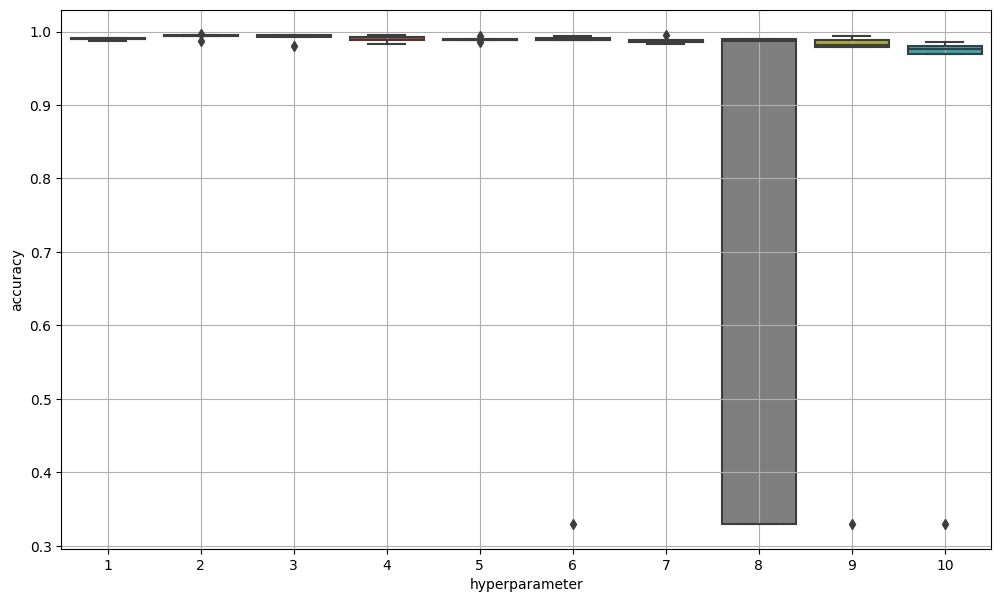

In [8]:
fig = pyplot.figure(figsize = (12, 7))
ax = fig.add_subplot(111)
boxplot(results, x = 'hyperparameter', y = 'accuracy', ax = ax)
ax.grid()

#### TESTING

In [9]:
dir_images_test = "C:\\zImagens\\imagensreais"

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=dir_images_test,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=1,
    image_size=image_size,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

test_images = []
test_labels = []

for image, label in test_ds:
    test_images.append(image.numpy())
    test_labels.append(label.numpy())

test_images = numpy.concatenate(test_images, axis = 0)
test_labels = numpy.concatenate(test_labels, axis = 0)

Found 30 files belonging to 3 classes.


In [10]:
best_model = results.sort_values("val_accuracy", ascending = False).head(1)['rps'].values[0]
best_model_predict = best_model.predict(test_images)
best_model_predict = numpy.argmax(best_model_predict, axis = 1)
best_model_history = results.sort_values("val_accuracy", ascending = False).head(1)['history'].values[0]
accuracy_score(test_labels, best_model_predict)

1/1 [==============================] - 0s 400ms/step


0.5

TRUE CLASS: paper >> PREDICTED CLASS: paper


0.5

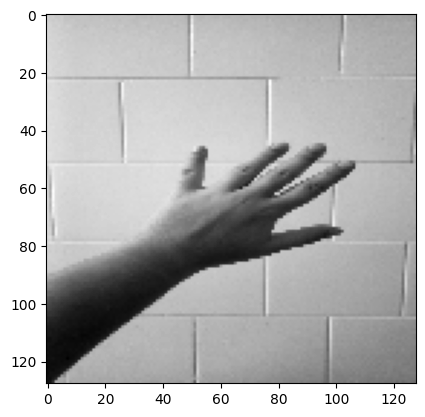

In [11]:
image_id = 16
print(f"TRUE CLASS: {class_names[test_labels[image_id]]} >> PREDICTED CLASS: {class_names[best_model_predict[image_id]]}")
# Y_test[image_id, :]
pyplot.imshow(test_images[image_id], cmap='gray')
accuracy_score(test_labels, best_model_predict)

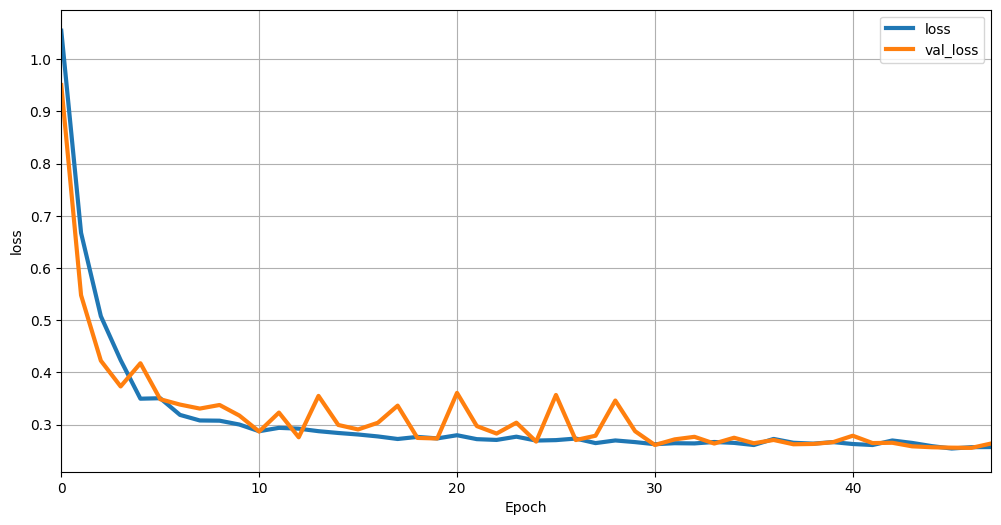

In [12]:
best_epoch = len(best_model_history.history['loss'][:-patience - 1])
best_val_loss = best_model_history.history['val_loss'][-patience - 1]
best_val_metric = best_model_history.history[f'val_{score_metric}'][-patience - 1]

fig = pyplot.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
_ = ax.plot(best_model_history.history['loss'], label='loss', linewidth=3)
_ = ax.plot(best_model_history.history['val_loss'], label = 'val_loss', linewidth=3)
_ = ax.scatter(x=[best_epoch], y=[best_val_loss], marker='*', s=1000, color='green')
_ = ax.grid(which='both')
_ = ax.set_xlim([0, 47])
_ = pyplot.xlabel('Epoch')
_ = pyplot.ylabel('loss')
_ = ax.legend(loc='upper right')
_ = ax.annotate(f'Melhor Rede: {100.0*best_val_metric:.0f}% {score_metric.lower()} {best_epoch} epoch',
                (best_epoch, best_val_loss),
                (1.025*best_epoch, 1.33*best_val_loss))

['paper', 'rock', 'scissors']


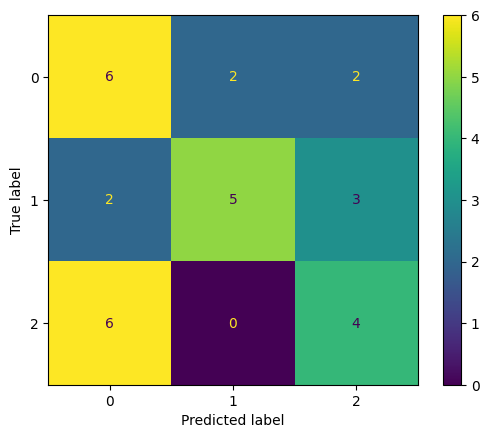

In [13]:
ConfusionMatrixDisplay.from_predictions(test_labels, best_model_predict)
print(class_names)

In [14]:
prediction_list  = []
for y_true, y_pred in zip(test_labels, best_model_predict):
    prediction_list.append((y_true, y_pred))
    
df_pred = pandas.DataFrame.from_records(prediction_list, columns = ['y_true', 'y_pred'])

ix_true = df_pred.y_true == 1
ix_pred = df_pred.y_pred == 2

df_pred.loc[ix_true & ix_pred, :]

,y_true,y_pred
4,1,2
13,1,2
27,1,2
